## Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from keras.api.models import Sequential
from keras.api.layers import Dense, Dropout
from keras.api.optimizers import Adam
import shap
import seaborn as sns
from sklearn.decomposition import PCA

d:\Students\YearThree\Term2\AI\Codes\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## เตรียมโหลดและข้อมูล

In [5]:
# โหลดข้อมูล
path = "D:\\Students\\YearThree\\Term2\\AI\\Codes\\Artificial_Intelligence\\Project_AI\\updated_pollution_dataset.csv"
data = pd.read_csv(path)

# แปลงค่า Label (Air Quality) เป็นตัวเลข
label_encoder = LabelEncoder()
data['Air Quality'] = label_encoder.fit_transform(data['Air Quality'])
# เก็บชื่อคลาส Good Hazardous Moderate Poor ลง class_names
class_names = label_encoder.classes_ 

# แยก Features และ Target
X = data.drop(columns=['Air Quality']).values  # เอาแค่ส่วน Features
y = data['Air Quality'].values  # เอาแค่ Target

# แบ่งข้อมูลเป็น Train/Test
# ทดสอบ train 90% test 10%, train 80% test 20%, train 70% test 30%
# ผลที่ดีสุดเป็น train 80% test 20% epochs=50 batch_size=32
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

# มาตรฐานข้อมูล (Standardization)
# ทำให้ค่าของแต่ละ feature อยู่ในช่วงที่เหมาะสม ลดปัญหา bias
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## สร้างและฝึกโมเดล

In [6]:
# สร้าง Neural Network model (FNN)
# ทดสอบ Dense 128 64, 64 32, 32 16
# 128 64 เยอะไป ผลลัพธ์เกิด Overfitting, 32 16 รู้สึกน้อยไปและถ้าเทียบกับ 64 32 ได้ผลลัพธ์ดีกว่า
# Dense ที่ใช้เป็น 64 กับ 32
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # Hidden Layer 1
    Dropout(0.3),  # ลด Overfitting โดยสุ่มปิด 30% ของ Neurons
    Dense(32, activation='relu'),  # Hidden Layer 2
    Dense(len(np.unique(y)), activation='softmax')  # Output Layer ใช้ Softmax สำหรับ Multi-class Classification ให้ค่าอยู่ในช่วง 0-1
])

# Compile model
# sparse_categorical_crossentropy เป็น loss function ที่เหมาะกับ multi-class classification และ Target ที่เรากำหนดเป็นตัวเลข
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train Model
# ทดสอบ epochs 30, 50, 70, 100 และ batch_size 16, 32, 64
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# ประเมินผลลัพธ์
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss * 100:.2f}%')
print(f'Accuracy: {accuracy * 100:.2f}%')


Epoch 1/50


d:\Students\YearThree\Term2\AI\Codes\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5384 - loss: 1.1052 - val_accuracy: 0.8580 - val_loss: 0.4352
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8397 - loss: 0.4319 - val_accuracy: 0.8870 - val_loss: 0.2849
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8647 - loss: 0.3309 - val_accuracy: 0.9140 - val_loss: 0.2309
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8945 - loss: 0.2631 - val_accuracy: 0.9190 - val_loss: 0.2093
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8945 - loss: 0.2631 - val_accuracy: 0.9260 - val_loss: 0.1935
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9100 - loss: 0.2373 - val_accuracy: 0.9340 - val_loss: 0.1800
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9117 - loss: 0.2203 - val_accuracy: 0.9340 - val_loss: 0.1759
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9155 - loss: 0.2154 - val_accuracy: 0.9380 - val_

## ทดสอบโมเดล

In [7]:
# ทดสอบโมเดล
# ใช้ np.argmax เลือกคลาสที่โมเดลพยากรณ์ว่ามีความเป็นไปได้สูงสุด (ค่ามากที่สุดของในแถว axis=1)
y_pred = np.argmax(model.predict(X_test), axis=1)

# แสดงผลตรวจสอบความแม่นยำของโมเดล
# ใช้วัด ประสิทธิภาพของโมเดล
# Precision >> ความแม่นยำของแต่ละคลาส (เช่น ค่าที่โมเดลทำนายว่า "Poor" จริง ๆ ถูกต้องแค่ไหน)
# Recall >> ความสามารถในการจับค่าของแต่ละคลาส (ค่าจริงของ "Poor" ถูกจับได้ทั้งหมดไหม)
# F1-score >> ค่าเฉลี่ยของ Precision และ Recall
# Support >> จำนวนตัวอย่างของแต่ละคลาส
# Macro Average >> ค่าเฉลี่ยของแต่ละคลาส (ไม่สนใจขนาดคลาส)
# Weighted Average >> ค่าเฉลี่ยแบบ ถ่วงน้ำหนักตามขนาดคลาส
print(classification_report(y_test, y_pred, target_names=class_names))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

        Good       1.00      1.00      1.00       409
   Hazardous       0.91      0.84      0.87       111
    Moderate       0.97      0.96      0.96       294
        Poor       0.85      0.90      0.87       186

    accuracy                           0.95      1000
   macro avg       0.93      0.92      0.93      1000
weighted avg       0.95      0.95      0.95      1000



## Confusion Matrix

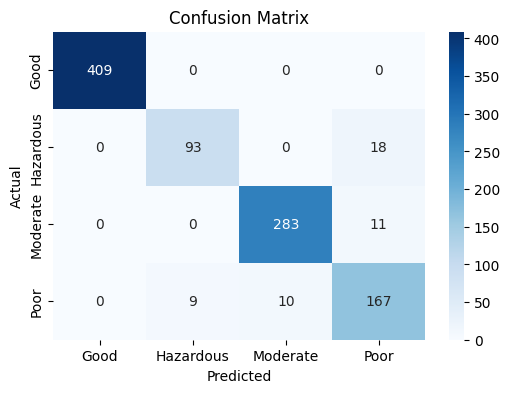

In [8]:
# แสดง Confusion Matrix
# เพื่อทดสอบว่าโมเดลสามารถใช้งานได้จริงแค่ไหน โดยแปลงค่าผลลัพธ์กลับเป็นหมวดหมู่ (Good, Moderate, Poor, Hazardous)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Plot Decision Boundary

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step


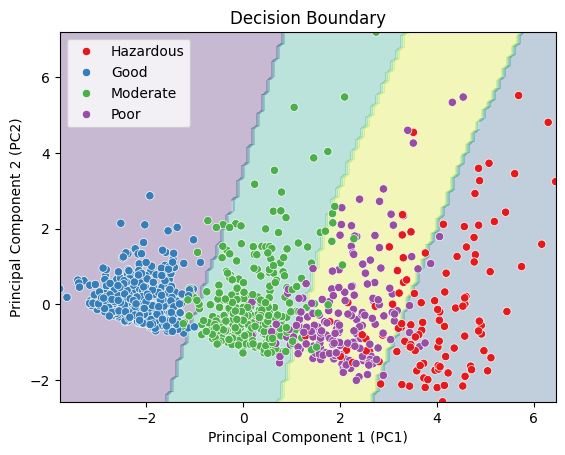

     Temperature  Humidity     PM2.5      PM10       NO2       SO2        CO  \
PC1     0.339407  0.303429  0.209689  0.268628  0.370598  0.373624  0.421226   
PC2    -0.108832 -0.085644  0.701184  0.626337 -0.140005 -0.157191 -0.124867   

     Proximity_to_Industrial_Areas  Population_Density  
PC1                      -0.355760            0.309305  
PC2                       0.119934           -0.150258  


In [14]:
# Plot Decision Boundary (ใช้ PCA ลดมิติ)
pc1_label = "Principal Component 1 (PC1)"
pc2_label = "Principal Component 2 (PC2)"
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test)
xx, yy = np.meshgrid(np.linspace(X_pca[:, 0].min(), X_pca[:, 0].max(), 100),
                     np.linspace(X_pca[:, 1].min(), X_pca[:, 1].max(), 100))
Z = model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.3)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=[class_names[i] for i in y_test], palette='Set1')
plt.xlabel(pc1_label)
plt.ylabel(pc2_label)
plt.title("Decision Boundary")
plt.show()
print(pd.DataFrame(pca.components_, columns=data.drop(columns=['Air Quality']).columns, index=['PC1', 'PC2']))


## เช็ค Overfitting หรือ Underfitting

Training Accuracy: 0.96, Test Accuracy: 0.95


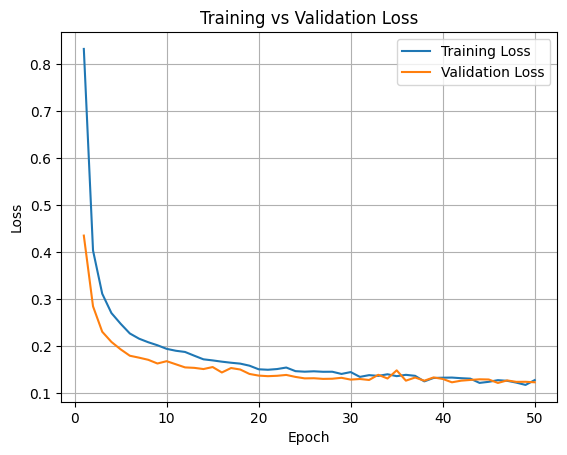

In [10]:
# เช็ค Overfitting หรือ Underfitting
# Accuracy ระหว่าง Train กับ Test
# Overfitting >> Train Accuracy สูง แต่ Test Accuracy ต่ำมาก 
# Underfitting >> Train & Test Accuracy ต่ำ
train_acc = model.evaluate(X_train, y_train, verbose=0)[1]  # [loss, accuracy] >> [1]
test_acc = model.evaluate(X_test, y_test, verbose=0)[1]     # [loss, accuracy] >> [1]
print(f'Training Accuracy: {train_acc:.2f}, Test Accuracy: {test_acc:.2f}')

# Overfitting >> Training loss ต่ำ แต่ Validation loss สูง
# Underfitting >> ทั้ง Training และ Validation loss สูง
# ดึงค่าจาก history
loss = history.history['loss']               # Training Loss
val_loss = history.history['val_loss']       # Validation Loss
epochs = range(1, len(loss) + 1)             # จำนวน Epochs
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.grid(True)
plt.show()

## Features สำคัญ

ExactExplainer explainer: 1001it [00:37, 27.00it/s]                         


SHAP Feature Importance for Good


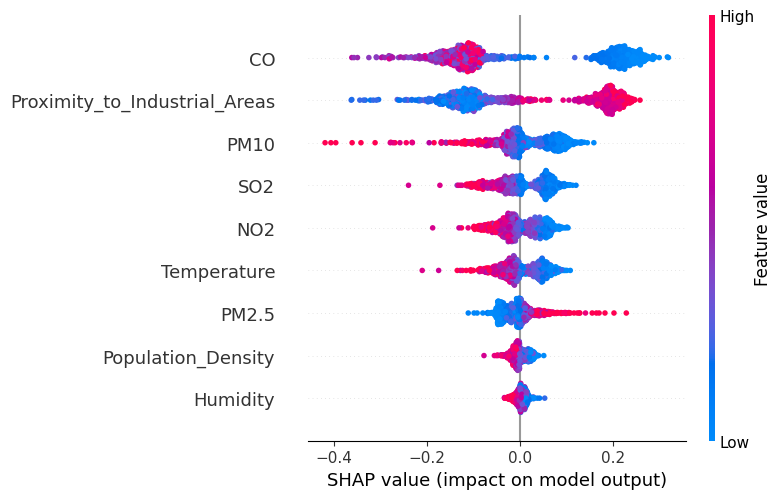

SHAP Feature Importance for Hazardous


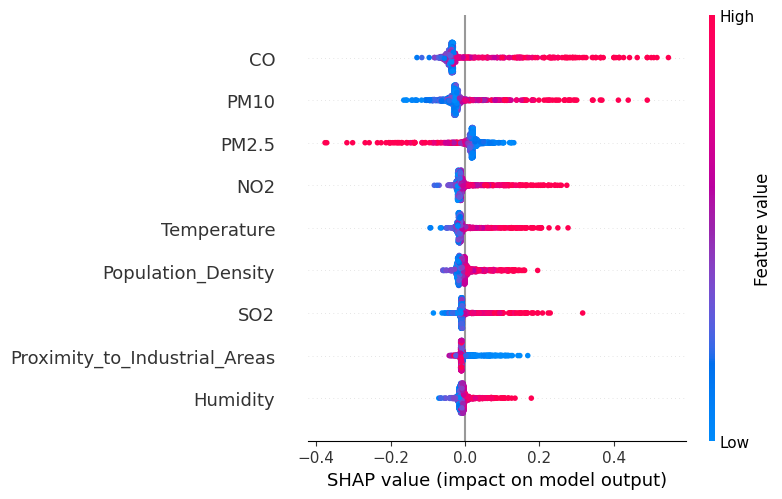

SHAP Feature Importance for Moderate


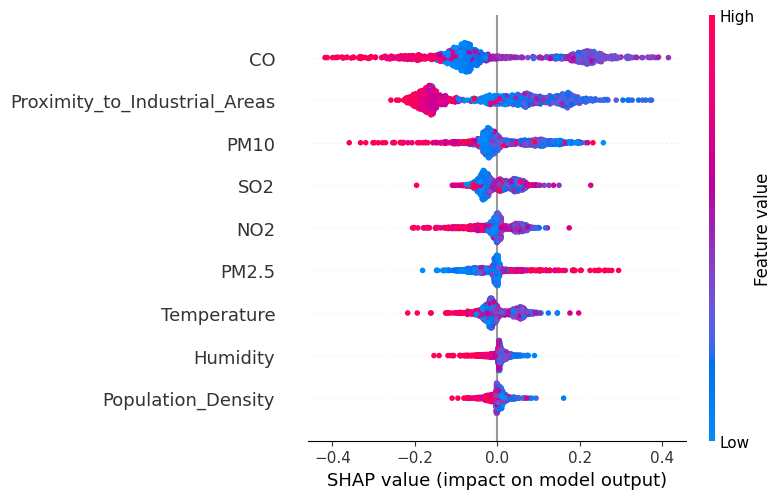

SHAP Feature Importance for Poor


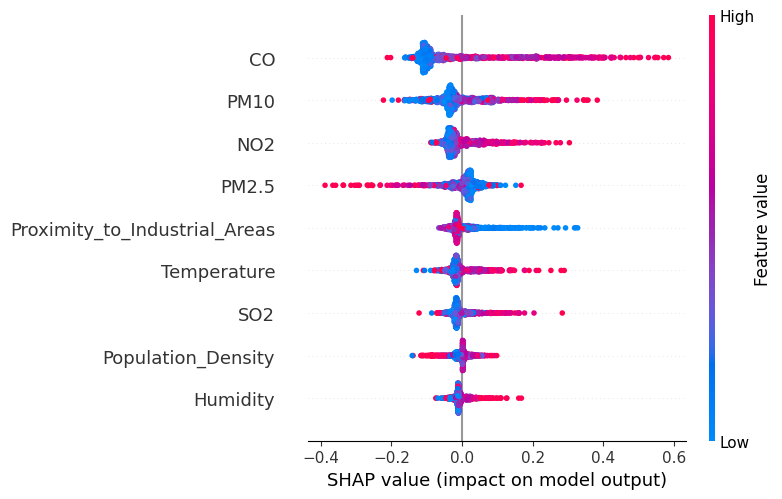

In [11]:
# Feature Importance using SHAP
# ใช้โมเดลที่ฝึกแล้วมาสร้าง Explainer
explainer = shap.Explainer(model, X_train)
# ดูว่าแต่ละ Feature มีผลต่อการพยากรณ์มากแค่ไหน
shap_values = explainer(X_test)
# Plot กราฟผลรวม
# สีแดง: ดันค่าพยากรณ์ให้สูง
# สีฟ้า: ลดค่าพยากรณ์
# Feature สำคัญ >> จุดเยอะและกระจายมาก
# Feature มีผลน้อย >> จุดแคบและเรียงกัน
# # แสดง Feature Importance ของทุกคลาสในกราฟเดียว
# shap.summary_plot(shap_values, features=X_test, feature_names=data.drop(columns=['Air Quality']).columns)

# แสดง Feature Importance ตาม Class
for i, class_name in enumerate(class_names):
    print(f"SHAP Feature Importance for {class_name}")
    shap.summary_plot(shap_values[:, :, i], features=X_test, feature_names=data.drop(columns=['Air Quality']).columns)

## ทดลอง Perdict อากาศ

In [12]:
# ข้อมูลใหม่ (สมมติค่าจาก Sensor)
new_data = np.array([[26.2,49.9,0.5,2,22.9,2.3,0.94,17.9,581]])  # ค่า Feature เช่น อุณหภูมิ, ความชื้น ฯลฯ

# ทำ Standardization เหมือนกับที่ใช้ตอน Train
new_data_scaled = scaler.transform(new_data)

# ทำนายค่า Air Quality
prediction = np.argmax(model.predict(new_data_scaled), axis=1)
predicted_label = class_names[prediction[0]]  # แปลงกลับเป็นชื่อคลาส

print(f'Predicted Air Quality: {predicted_label}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted Air Quality: Good
